## **IMPORT**

In [1]:
import warnings
warnings.filterwarnings('ignore')

from ChessEngine import *
from numba.cuda.cudadrv.driver import CudaAPIError
import pandas as pd
import time
import math

def find_move_benchmark_all(fen: str, search_depth: int, versions: dict[int, str]):
    result_df = pd.DataFrame()

    num_versions = len(versions)
    cols = math.ceil(math.sqrt(num_versions))
    rows = math.ceil(num_versions / cols)

    fig, axs = plt.subplots(rows, cols, figsize = (8 * cols, 8 * rows), squeeze = False)

    row, col = 0, 0

    for version, version_name in versions.items():
        game = ChessGame(fen)
        start = time.time()
        move, score = find_move(game, search_depth, version=version)
        end = time.time()

        result_df = pd.concat([result_df, pd.DataFrame({
            'Version'         : [version_name],
            'Score'           : [score],
            'Execution time'  : [end - start],
            'No. Evaluations' : [get_evaluation_count()]
        }, index=[version])])

        moves = None if move is None else [move]
        axs[row, col].set_title(version_name, fontdict={'fontsize': 20, 'fontweight': 'medium'})
        game.plot(moves=moves, ax=axs[row, col])
        col += 1
        if col >= cols:
            col = 0
            row += 1

    while row < rows:
        (axs[row, col] if rows > 1 else axs[col]).set_visible(False)
        col += 1
        if col >= cols:
            col = 0
            row += 1

    return result_df

## **TESTS**

### SEARCH DEPTH 4

,Version,Score,Execution time,No. Evaluations
0,Sequential,-1.2,376.515349,3107697
1,Sequential + Alpha-beta,-1.2,2.342766,16293
2,Sequential + Alpha-beta + Move sorting,-1.2,1.556737,8579
3,Parallel v1,-1.2,118.280308,3107697
4,Parallel v1 + Alpha-beta,-1.2,4.153125,107193
5,Parallel v1 + Alpha-beta + Move sorting,-1.2,4.103853,102329
6,Parallel v2,-1.2,4.833068,3107697
7,Parallel v2 + Alpha-beta,-1.2,0.068841,28920


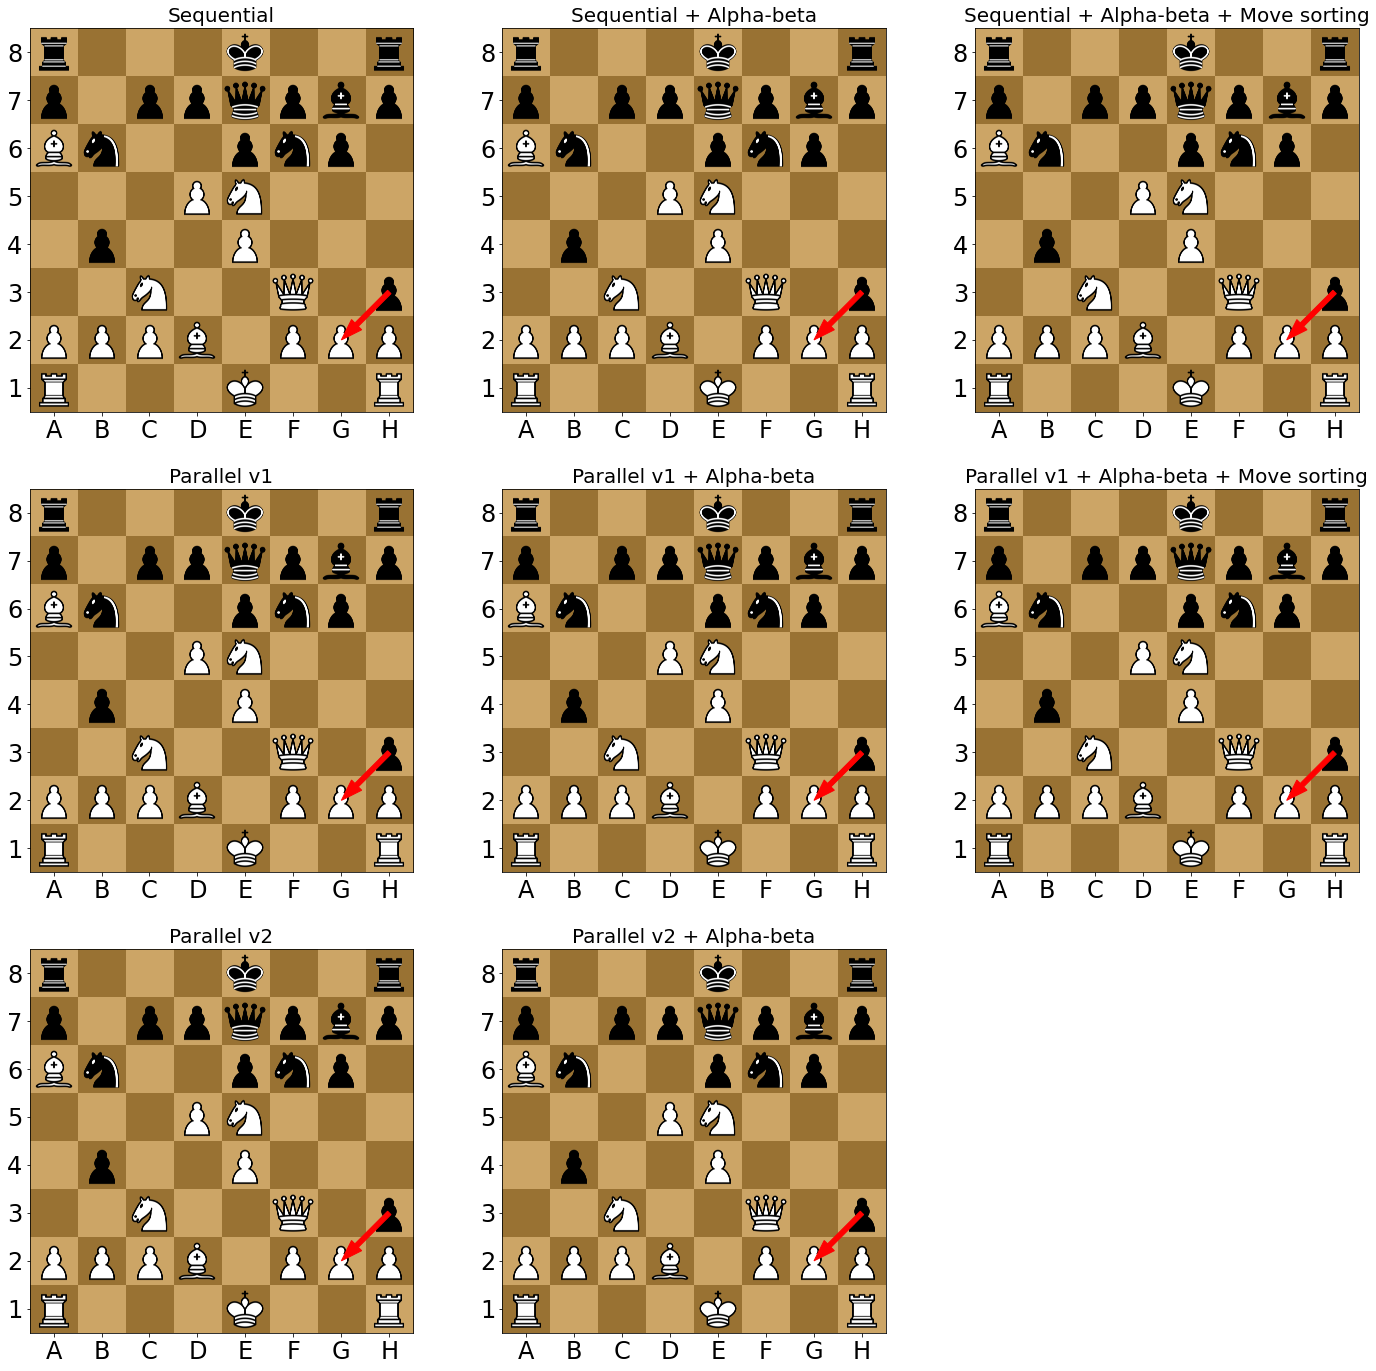

In [2]:
try:
    result_sd4 = find_move_benchmark_all('r3k2r/p1ppqpbp/Bn2pnp1/3PN3/1p2P3/2N2Q1p/PPPB1PPP/R3K2R b KQkq - 0 1', 4, {
        0: 'Sequential',
        1: 'Sequential + Alpha-beta',
        2: 'Sequential + Alpha-beta + Move sorting',
        3: 'Parallel v1',
        4: 'Parallel v1 + Alpha-beta',
        5: 'Parallel v1 + Alpha-beta + Move sorting',
        6: 'Parallel v2',
        7: 'Parallel v2 + Alpha-beta'
    })
except CudaAPIError as e:
    print(e.msg)
result_sd4
